In [1]:
Import all libraries

SyntaxError: invalid syntax (<ipython-input-1-668bf34cc7d1>, line 1)

In [2]:
import csv
import glob
import random

import numpy as np

import matplotlib.pyplot as plt
import cv2
import os
# from keras.models import Model
# from keras.layers import Input, merge, Convolution2D, MaxPooling2D, convolutional
#
# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
# from keras import backend as K

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
#from tensorflow.python.layers.convolutional import Conv2DTranspose

Using TensorFlow backend.


In [3]:
%matplotlib inline

In [4]:
dataroot = "dataset/object-detection-crowdai/"
# read CSV file into lines list
def read_csv(file):
    lines = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile, skipinitialspace=True)
        for line in reader:
            if (line[5] == "Car") | (line[5] == "Truck"):
                lines.append(line)
    return lines

labels = read_csv('dataset/object-detection-crowdai/labels.csv')
print(len(labels))

# generate mask files
curr_file = None
curr_mask = None
# masks =[]
# frames = []
data = []
img = None
counter =0
for label in labels:
    filename = label[4]
    if filename != curr_file:

        if img is not None:
            imgfile = dataroot + curr_file
            maskfile = dataroot + "masks/mask_" + curr_file
            cv2.imwrite(maskfile, curr_mask)
            if (os.path.exists(imgfile) and os.path.isfile(imgfile) and os.path.exists(maskfile) and os.path.isfile(maskfile)):
                data.append((imgfile, maskfile))

            #img[curr_mask == 0] = 0
            # cv2.imshow("masked scene", img)
            # cv2.waitKey()

        # create new mask
        curr_file = filename
        img = cv2.imread((dataroot + label[4]))

        curr_mask = np.zeros_like(img[:,:,0] )
        # masks.append(curr_mask)
        # frames.append(curr_file)
    p1 = (int(label[0]), int(label[1]))
    p2 = (int(label[2]), int(label[3]))
    cv2.rectangle(curr_mask, p1, p2, (1), thickness=-1)
    counter +=1
    if counter %1000 == 0:
        print("processed " + str(counter) + " labels")

# save last mask
imgfile = dataroot + curr_file
maskfile = dataroot + "masks/mask_" + curr_file

cv2.imwrite(maskfile, curr_mask)
if (os.path.exists(imgfile) and os.path.isfile(imgfile) and os.path.exists(maskfile) and os.path.isfile(maskfile)):
    data.append((imgfile, maskfile))

66389
processed 1000 labels
processed 2000 labels
processed 3000 labels
processed 4000 labels
processed 5000 labels
processed 6000 labels
processed 7000 labels
processed 8000 labels
processed 9000 labels
processed 10000 labels
processed 11000 labels
processed 12000 labels
processed 13000 labels
processed 14000 labels
processed 15000 labels
processed 16000 labels
processed 17000 labels
processed 18000 labels
processed 19000 labels
processed 20000 labels
processed 21000 labels
processed 22000 labels
processed 23000 labels
processed 24000 labels
processed 25000 labels
processed 26000 labels
processed 27000 labels
processed 28000 labels
processed 29000 labels
processed 30000 labels
processed 31000 labels
processed 32000 labels
processed 33000 labels
processed 34000 labels
processed 35000 labels
processed 36000 labels
processed 37000 labels
processed 38000 labels
processed 39000 labels
processed 40000 labels
processed 41000 labels
processed 42000 labels
processed 43000 labels
processed 4400

In [5]:
def histogram_normalization(image):
    b, g, r = cv2.split(image)
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)
    r = cv2.equalizeHist(r)

    return cv2.merge([b,g,r])

In [7]:
def generate_train_batch(datalist, batch_size):
    width=608
    height=320
    batch_images = np.zeros((batch_size, height, width, 3))
    batch_masks = np.zeros((batch_size,height, width, 1))
    while 1:
        for i_batch in range(batch_size):

            #data
            #img_name, img, bb_boxes = im_read(data, process_line, resize=True, size=(col, row), augumentation=True,
            #                                  display=False)
            #img_masked = get_mask_seg(img, bb_boxes)
            randno = random.randint(0, len(datalist) -1)
            img = cv2.imread(datalist[randno][0])
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = histogram_normalization(img)
            mask = cv2.imread(datalist[randno][1], cv2.IMREAD_UNCHANGED)
            # cv2.imshow("img", img)
            # cv2.imshow("mask", mask)
            # cv2.waitKey()

            img = cv2.resize(img, (width, height))
            mask = cv2.resize(mask, (width, height))
            # cv2.imshow("resized img", img)
            # cv2.imshow("resized mask", mask)
            # cv2.waitKey()

            batch_images[i_batch] = img
            mask = mask[:,:, np.newaxis]
            batch_masks[i_batch] = mask
        yield batch_images, batch_masks

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

def get_unet():
    inputs = Input((320, 608, 3))
    inputs_norm = Lambda(lambda x: x / 127.5 - 1.)(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs_norm)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

    return model

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = get_unet()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='IOU_calc_loss', save_best_only=True)

------------------------------
Creating and compiling model...
------------------------------


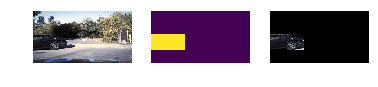

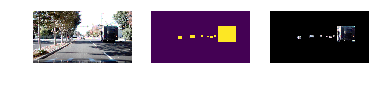

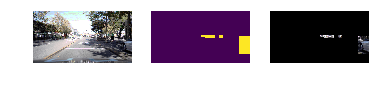

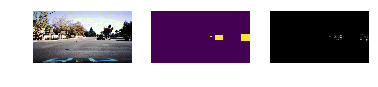

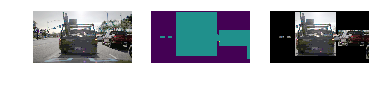

In [8]:
# test the generator
test_gen = generate_train_batch(data, 5)
batch_img,batch_mask = next(test_gen)
### Plotting generator output
for i in range(5):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

In [9]:
print('-'*30)
print('Fitting model...')
print('-'*30)

model.fit_generator(generate_train_batch(data, 16), steps_per_epoch=200, epochs=5, verbose=1, callbacks=[model_checkpoint]) # validation_split=0.2, batch_size=32,


#cv2.waitKey()

------------------------------
Fitting model...
------------------------------
Epoch 1/5
200/200 [==============================] - 201s - loss: -0.3140 - IOU_calc: 0.3140      

C:\Users\Florian\Miniconda3\envs\flow-gpu\lib\site-packages\keras\callbacks.py:390: RuntimeWarning: Can save best model only with IOU_calc_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/5
200/200 [==============================] - 191s - loss: -0.5541 - IOU_calc: 0.5541     

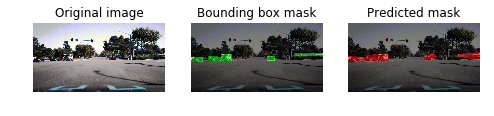

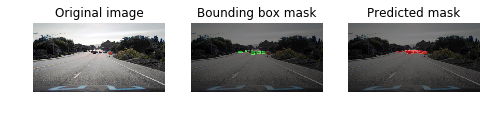

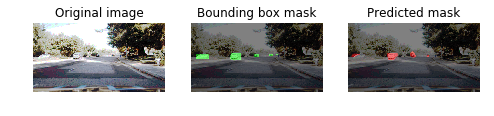

In [10]:
batch_img,batch_mask = next(test_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

for i in range(3):
    
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_pred) #  #pred_all[i][:,:,0], cmap='Greys'
    plt.title('Predicted mask')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_true) #batch_mask[i][:,:,0], cmap='Greys'
    plt.axis('off')
    plt.title('Bounding box mask')
    plt.savefig('report images/img_mask_detection' + str(i) + '.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
plt.savefig('report images/img_mask_detection.png', format='png', dpi=1200)

In [18]:
### Save weights 
model.save_weights("sem_seg_unet30e_w_norm.h5")
model.save("sem_seg_unet30e_norm.h5")

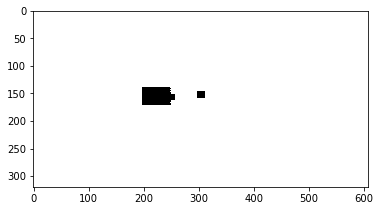

In [19]:
width=608
height=320
randno = random.randint(0, len(data) -1)
img = cv2.imread(data[randno][0])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
mask = cv2.imread(data[randno][1], cv2.IMREAD_UNCHANGED)

img = cv2.resize(img, (width, height))
img = img[np.newaxis,:,:,:]
mask = cv2.resize(mask, (width, height))

mask = mask[np.newaxis,:,:]
plt.imshow(mask[0], cmap='Greys',  interpolation='nearest')
#plt.imshow(img[0])

TypeError: Invalid dimensions for image data

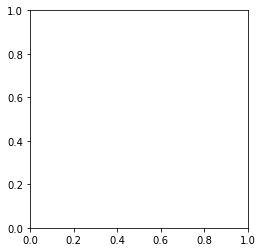

In [25]:
new_mask = model.predict(img)
plt.imshow(new_mask[0])
#cv2.imshow("new predicted mask", new_mask[0])